In [1]:
!pip install yfinance ccxt pandas numpy matplotlib scikit-learn tensorflow transformers


In [2]:
# Import libraries
import yfinance as yf
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from transformers import pipeline


In [4]:
# Function to fetch stock data
def fetch_stock_data(ticker, start_date='2020-01-01'):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    return df

def fetch_crypto_data(symbol='BTC/USD', exchange='kraken'):
    exchange_class = getattr(ccxt, exchange)
    exchange_instance = exchange_class()
    ohlcv = exchange_instance.fetch_ohlcv(symbol, timeframe='1d', limit=1000)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# Example usage
btc_data = fetch_crypto_data('BTC/USD', exchange='kraken')
eth_data = fetch_crypto_data('ETH/USD', exchange='kraken')
print(btc_data.head())


# Fetch data for Apple, Tesla, Bitcoin, and Ethereum
apple_data = fetch_stock_data('AAPL', '2020-01-01')
tesla_data = fetch_stock_data('TSLA', '2020-01-01')
btc_data = fetch_crypto_data('BTC/USDT')
eth_data = fetch_crypto_data('ETH/USDT')

# Show sample data
print("Apple Data:\n", apple_data.head())
print("\nBitcoin Data:\n", btc_data.head())


   timestamp     open     high      low    close       volume
0 2023-01-22  22785.6  23108.5  22301.2  22717.1  3113.012916
1 2023-01-23  22717.1  23166.6  22520.1  22926.1  3015.649855
2 2023-01-24  22926.0  23158.7  22455.9  22633.8  3077.643596
3 2023-01-25  22636.0  23829.3  22320.0  23056.5  5020.204657
4 2023-01-26  23063.2  23293.3  22857.5  23010.6  3753.163921
Apple Data:
                   timestamp       open       high        low      close  \
0 2020-01-02 00:00:00-05:00  71.799881  72.856621  71.545395  72.796028   
1 2020-01-03 00:00:00-05:00  72.020432  72.851761  71.862892  72.088295   
2 2020-01-06 00:00:00-05:00  71.206085  72.701508  70.954017  72.662727   
3 2020-01-07 00:00:00-05:00  72.672409  72.929322  72.100418  72.320976   
4 2020-01-08 00:00:00-05:00  72.022858  73.787315  72.022858  73.484352   

      volume  
0  135480400  
1  146322800  
2  118387200  
3  108872000  
4  132079200  

Bitcoin Data:
    timestamp     open     high      low    close      volu

In [5]:
# Load FinBERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# Function to add sentiment scores
def add_sentiment_to_data(data):
    # Placeholder sentiment text for demonstration
    data['sentiment_text'] = "The market sentiment is positive."  # Example text
    data['sentiment_score'] = [
        sentiment_pipeline(text)[0]['score'] for text in data['sentiment_text']
    ]
    return data

# Add sentiment scores
apple_data = add_sentiment_to_data(apple_data)
tesla_data = add_sentiment_to_data(tesla_data)
btc_data = add_sentiment_to_data(btc_data)
eth_data = add_sentiment_to_data(eth_data)

# Show sample data with sentiment scores
print("\nApple Data with Sentiment:\n", apple_data.head())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Apple Data with Sentiment:
                   timestamp       open       high        low      close  \
0 2020-01-02 00:00:00-05:00  71.799881  72.856621  71.545395  72.796028   
1 2020-01-03 00:00:00-05:00  72.020432  72.851761  71.862892  72.088295   
2 2020-01-06 00:00:00-05:00  71.206085  72.701508  70.954017  72.662727   
3 2020-01-07 00:00:00-05:00  72.672409  72.929322  72.100418  72.320976   
4 2020-01-08 00:00:00-05:00  72.022858  73.787315  72.022858  73.484352   

      volume                     sentiment_text  sentiment_score  
0  135480400  The market sentiment is positive.         0.807533  
1  146322800  The market sentiment is positive.         0.807533  
2  118387200  The market sentiment is positive.         0.807533  
3  108872000  The market sentiment is positive.         0.807533  
4  132079200  The market sentiment is positive.         0.807533  


In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Function to preprocess data
def preprocess_data(data, feature_cols=['close', 'sentiment_score'], seq_length=60):
    """
    Scales the selected features and creates sequences of `seq_length`.
    Returns the preprocessed data as X (input), y (output), and the scaler object.
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[feature_cols])  # Scale selected features

    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i-seq_length:i])  # Sequence input
        y.append(scaled_data[i, 0])  # Predict close price

    return np.array(X), np.array(y), scaler

# Sequence length
seq_length = 60

# Preprocess Apple, Tesla, Bitcoin, and Ethereum datasets
X_apple, y_apple, apple_scaler = preprocess_data(apple_data)
X_tesla, y_tesla, tesla_scaler = preprocess_data(tesla_data)
X_btc, y_btc, btc_scaler = preprocess_data(btc_data)
X_eth, y_eth, eth_scaler = preprocess_data(eth_data)

# Print dataset shapes for verification
print(f"Apple Data: X shape {X_apple.shape}, y shape {y_apple.shape}")
print(f"Tesla Data: X shape {X_tesla.shape}, y shape {y_tesla.shape}")
print(f"Bitcoin Data: X shape {X_btc.shape}, y shape {y_btc.shape}")
print(f"Ethereum Data: X shape {X_eth.shape}, y shape {y_eth.shape}")


Apple Data: X shape (1204, 60, 2), y shape (1204,)
Tesla Data: X shape (1204, 60, 2), y shape (1204,)
Bitcoin Data: X shape (660, 60, 2), y shape (660,)
Ethereum Data: X shape (660, 60, 2), y shape (660,)


In [8]:
# Function to split data into training and testing sets
def train_test_split(X, y, train_ratio=0.8):
    split_idx = int(len(X) * train_ratio)
    return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

# Split data
X_train_apple, X_test_apple, y_train_apple, y_test_apple = train_test_split(X_apple, y_apple)
X_train_tesla, X_test_tesla, y_train_tesla, y_test_tesla = train_test_split(X_tesla, y_tesla)
X_train_btc, X_test_btc, y_train_btc, y_test_btc = train_test_split(X_btc, y_btc)
X_train_eth, X_test_eth, y_train_eth, y_test_eth = train_test_split(X_eth, y_eth)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Function to build and train LSTM model
def build_and_train_lstm(X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
    return model, history

# Train models for all datasets
apple_model, _ = build_and_train_lstm(X_train_apple, y_train_apple, X_test_apple, y_test_apple)
tesla_model, _ = build_and_train_lstm(X_train_tesla, y_train_tesla, X_test_tesla, y_test_tesla)
btc_model, _ = build_and_train_lstm(X_train_btc, y_train_btc, X_test_btc, y_test_btc)
eth_model, _ = build_and_train_lstm(X_train_eth, y_train_eth, X_test_eth, y_test_eth)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0692 - val_loss: 0.0065
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0099
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Apple Stock Predictions - MSE: 0.0014648364270170866, RMSE: 0.03827318156381942


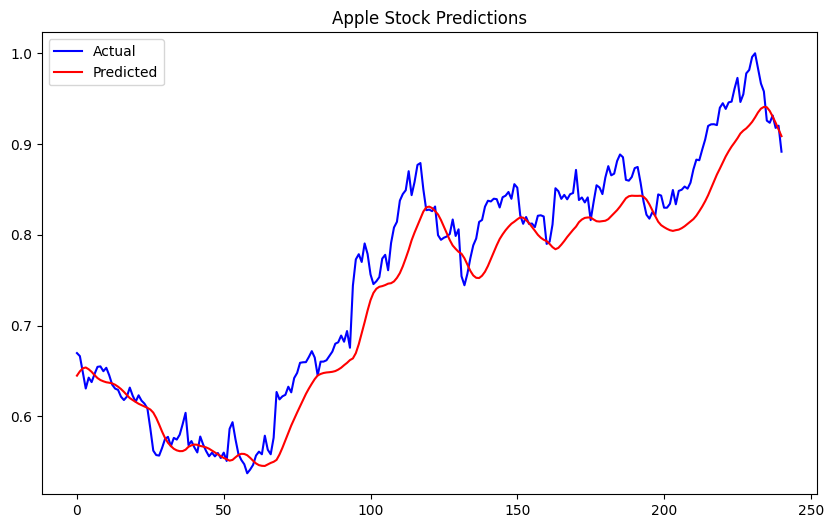

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Tesla Stock Predictions - MSE: 0.0016133169430655016, RMSE: 0.04016611685320728


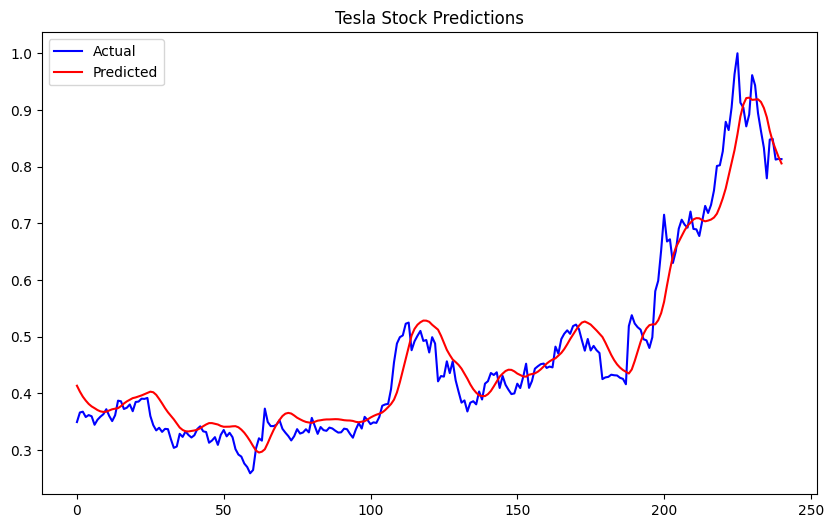

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Bitcoin Predictions - MSE: 0.0036622995586673437, RMSE: 0.06051693613086624


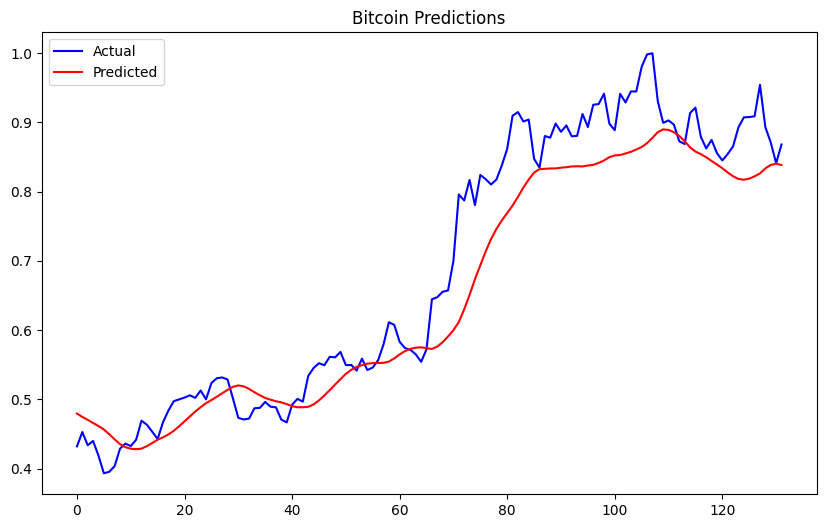

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Ethereum Predictions - MSE: 0.0043858796111687385, RMSE: 0.06622597384084841


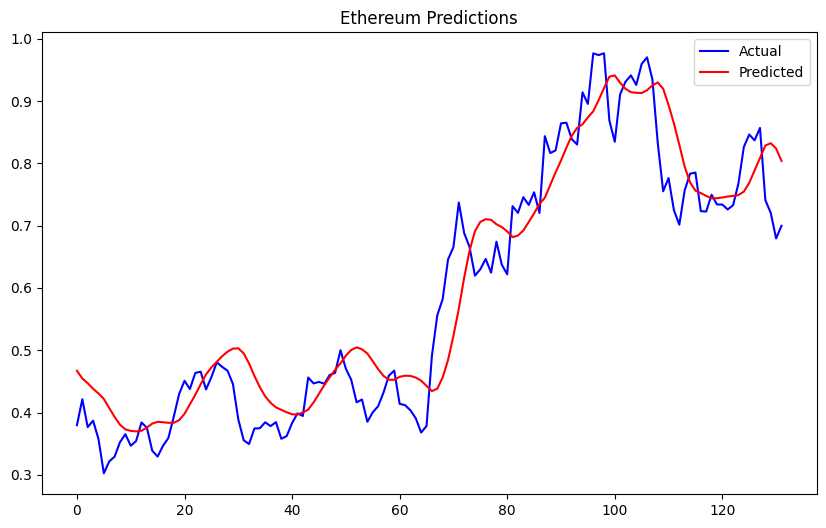

In [10]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to evaluate and visualize predictions
def evaluate_model(model, X_test, y_test, title):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    print(f"{title} - MSE: {mse}, RMSE: {rmse}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(title)
    plt.legend()
    plt.show()

# Evaluate Models
evaluate_model(apple_model, X_test_apple, y_test_apple, "Apple Stock Predictions")
evaluate_model(tesla_model, X_test_tesla, y_test_tesla, "Tesla Stock Predictions")
evaluate_model(btc_model, X_test_btc, y_test_btc, "Bitcoin Predictions")
evaluate_model(eth_model, X_test_eth, y_test_eth, "Ethereum Predictions")
